Number of building codes starting with F: 161
Number of building codes starting with G: 71
Number of building codes starting with H: 71


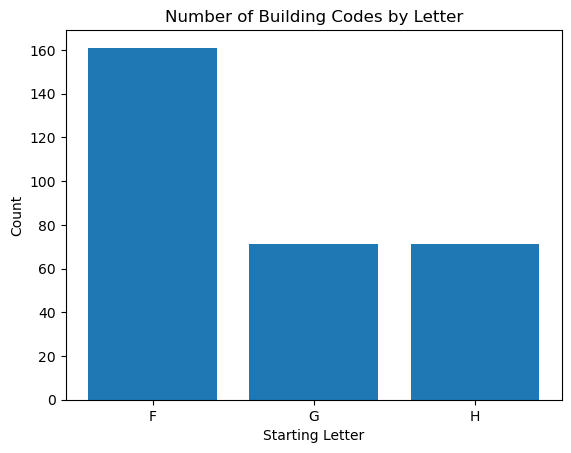


Top 10 Energy Consumers:
Meter_location
F523 Leith III, 279                              17157408.80
F522 Leith II, 281                               16199710.65
F320 PE Squash Courts                            15196659.00
D200 Whole Medical School:                       12007287.70
E201 Otago Dental School CSB  Chiller 1          11657474.00
E201 Otago Dental School CSB  Chiller 2          11023471.00
F408 65 Union Place west (HEDC)                   9876681.00
D204 Spark Inst. on Hercus Roof (room No 424)     8853409.00
E315 71 Frederick Room 101                        7020069.16
E201 Clinical Services Building MSB Total:        5733118.17
dtype: float64


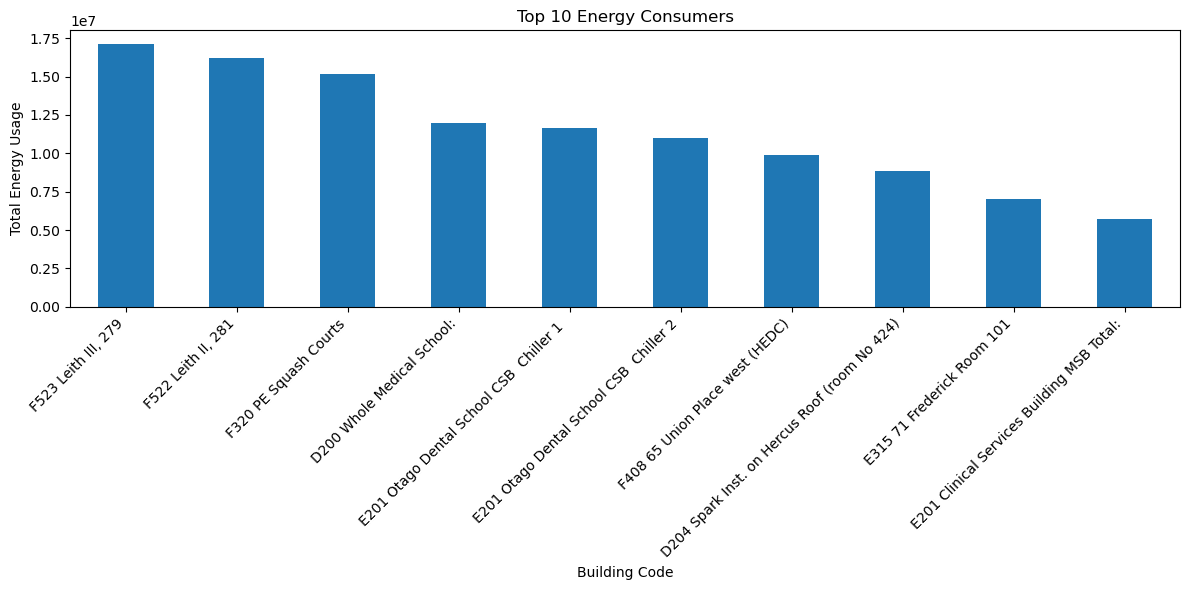

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv('Combined_Cleaned_Data.csv')

# Count the number of building codes starting with F, G, and H
f_codes = df[df['Meter_location'].str.startswith('F')]['Meter_location'].nunique()
g_codes = df[df['Meter_location'].str.startswith('G')]['Meter_location'].nunique()
h_codes = df[df['Meter_location'].str.startswith('H')]['Meter_location'].nunique()

print(f"Number of building codes starting with F: {f_codes}")
print(f"Number of building codes starting with G: {g_codes}")
print(f"Number of building codes starting with H: {h_codes}")

# Create a bar plot
labels = ['F', 'G', 'H']
counts = [f_codes, g_codes, h_codes]

plt.bar(labels, counts)
plt.title('Number of Building Codes by Letter')
plt.xlabel('Starting Letter')
plt.ylabel('Count')
plt.show()

# Calculate total energy usage for each building code
total_energy = df.set_index('Meter_location').iloc[:, 1:].sum(axis=1)

# Sort and display top 10 energy consumers
top_10 = total_energy.sort_values(ascending=False).head(10)
print("\nTop 10 Energy Consumers:")
print(top_10)

# Plot top 10 energy consumers
plt.figure(figsize=(12, 6))
top_10.plot(kind='bar')
plt.title('Top 10 Energy Consumers')
plt.xlabel('Building Code')
plt.ylabel('Total Energy Usage')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


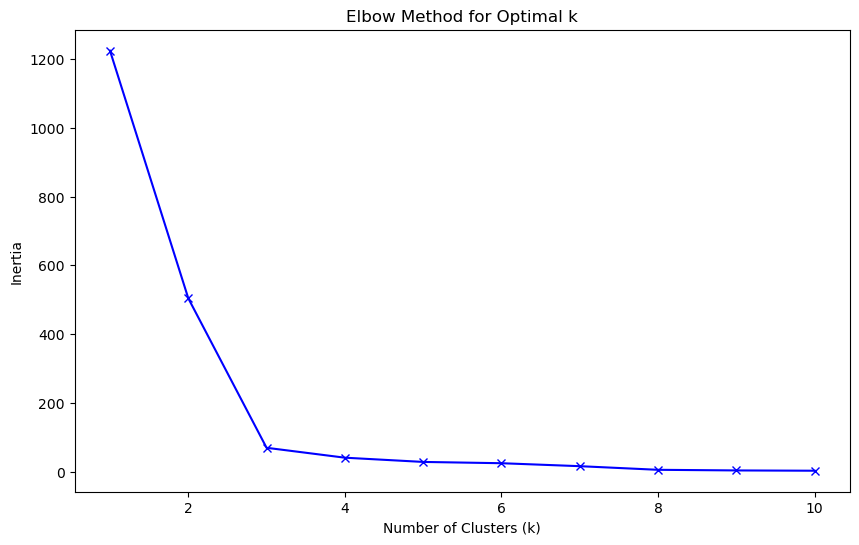

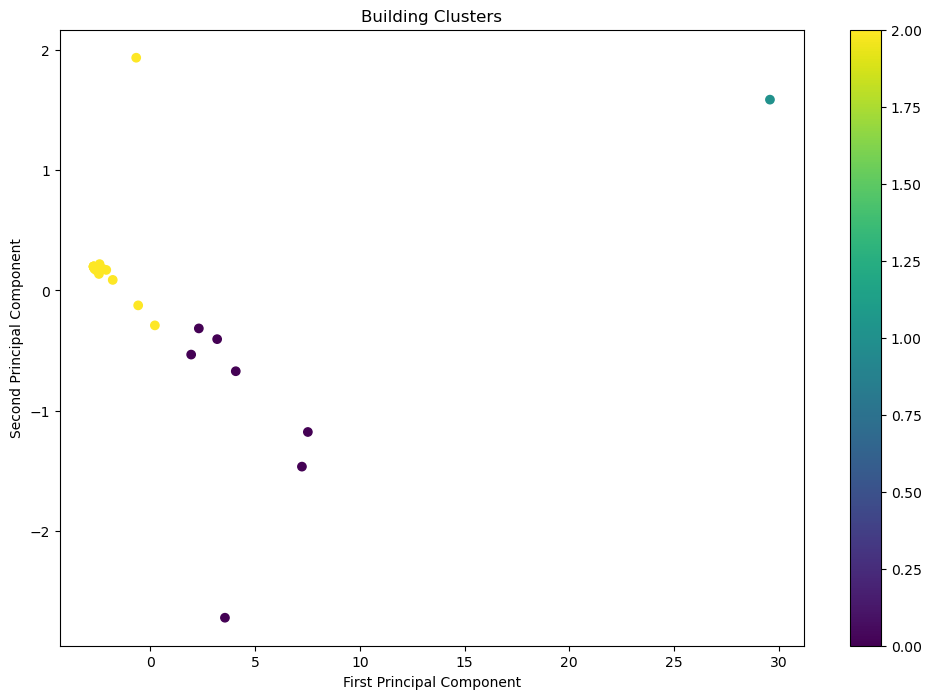


Cluster 0 buildings:
['F325 PhysEd Flume', 'F325 PhysEd Flume', 'F419 ISB East Excluding Plant', 'F419 ISB West Excluding Shops', 'G403 Biochemistry:', 'G404 Microbiology:', 'G411 St Davids Lecture Theatre total']

Cluster 1 buildings:
['F320 PE Squash Courts']

Cluster 2 buildings:
['F402 University Union Backfeed - Smithells, HEDC & Union Lawn:', 'F405 Smithells Gym and Portacoms:', 'F419 ISB east Lift:', 'F419 ISB west Humidifier:', 'F330 PE Squash Courts', 'F403 OUSA Total ', 'F405 Smithells Gym', 'F419 ISB East Submains/Difference', 'F419 ISB West Submains/Difference', 'G401 Mellor Chiller:', 'G403 Biochemistry Plant room East:', 'G403 Biochemistry Plant room West:', 'G404 Microbiology HVAC Ground:', 'G404 Microbiology Mech Basement :', 'G404 Microbiology Rooftop ONE.NZ Antenna', "G411 St David's generator:", 'G411 St Davids visitor centre:', 'G411 St Davids Lecture Theatre solar total', 'H402 St David II Mech??? :', 'H402 St David II Chiller:', 'H402 St David II DB GMS:', 'H402 

In [5]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('Combined_Cleaned_Data.csv')

# Function to extract numeric part from building codes
def extract_number(code):
    try:
        return int(''.join(filter(str.isdigit, str(code))))
    except:
        return 0

# Function to filter building codes within ranges
def filter_buildings(df, prefix, start, end):
    mask = (df['Meter_location'].str.startswith(prefix, na=False) & 
            df['Meter_location'].apply(lambda x: extract_number(x)).between(start, end))
    return df[mask]

# Filter the data for each building type
f_buildings = filter_buildings(df, 'F', 100, 500)
g_buildings = filter_buildings(df, 'G', 200, 500)
h_buildings = filter_buildings(df, 'H', 100, 432)

# Combine the filtered data
buildings = pd.concat([f_buildings, g_buildings, h_buildings])

# Prepare the data for clustering (excluding 'Category' and 'Meter_location')
X = buildings.iloc[:, 2:].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine optimal number of clusters using elbow method
inertias = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# Choose optimal k (let's use 3 clusters)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to the original dataframe
buildings['Cluster'] = cluster_labels

# Visualize clusters using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.title('Building Clusters')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter)
plt.show()

# Print buildings in each cluster
for i in range(optimal_k):
    print(f"\nCluster {i} buildings:")
    print(buildings[buildings['Cluster'] == i]['Meter_location'].tolist())


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('Combined_Cleaned_Data.csv')

# Function to filter and sum building data
def get_building_sums(df, prefix, start, end):
    mask = (df['Meter_location'].str.startswith(prefix, na=False) & 
            df['Meter_location'].str.extract('(\d+)').astype(float).between(start, end))
    return df[mask].iloc[:, 2:].sum()

# Get sums for each building type
f_sum = get_building_sums(df, 'F', 100, 500)
g_sum = get_building_sums(df, 'G', 200, 500)
h_sum = get_building_sums(df, 'H', 100, 432)

# Create a DataFrame with the sums
building_sums = pd.DataFrame({
    'F Buildings': f_sum,
    'G Buildings': g_sum,
    'H Buildings': h_sum
})

# Create box plot
plt.figure(figsize=(10, 6))
building_sums.boxplot()
plt.title('Distribution of Energy Usage by Building Type (2022-2024)')
plt.ylabel('Energy Usage')
plt.grid(True)
plt.show()

# Create bar chart showing yearly averages
yearly_averages = pd.DataFrame({
    '2022': [f_sum[:12].mean(), g_sum[:12].mean(), h_sum[:12].mean()],
    '2023': [f_sum[12:24].mean(), g_sum[12:24].mean(), h_sum[12:24].mean()],
    '2024': [f_sum[24:].mean(), g_sum[24:].mean(), h_sum[24:].mean()]
}, index=['F Buildings', 'G Buildings', 'H Buildings'])

yearly_averages.plot(kind='bar', figsize=(12, 6))
plt.title('Average Energy Usage by Building Type and Year')
plt.ylabel('Average Energy Usage')
plt.xlabel('Building Type')
plt.legend(title='Year')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print("\nF Buildings (Series 100-500):")
print(building_sums['F Buildings'].describe())
print("\nG Buildings (Series 200-500):")
print(building_sums['G Buildings'].describe())
print("\nH Buildings (Series 100-432):")
print(building_sums['H Buildings'].describe())


<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\d'
C:\Users\sugan\AppData\Local\Temp\ipykernel_4364\586639019.py:11: SyntaxWarning: invalid escape sequence '\d'
  df['Meter_location'].str.extract('(\d+)').astype(float).between(start, end))


AttributeError: 'DataFrame' object has no attribute 'between'

<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\d'
C:\Users\sugan\AppData\Local\Temp\ipykernel_4364\2834680473.py:11: SyntaxWarning: invalid escape sequence '\d'
  df['numeric_part'] = df['Meter_location'].str.extract('(\d+)').astype(float)


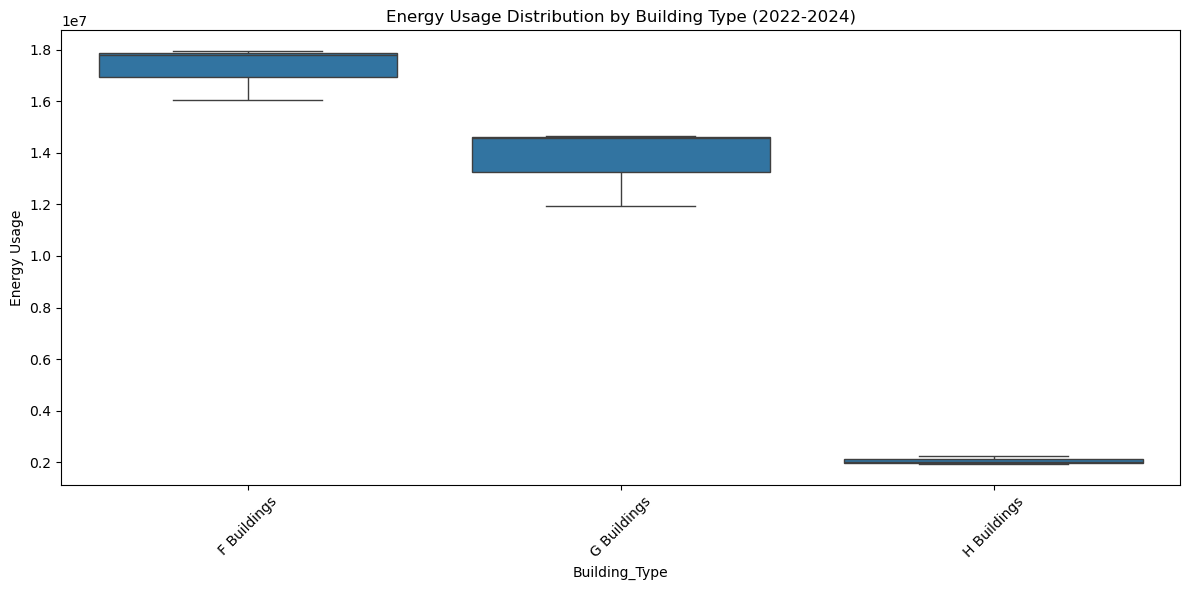

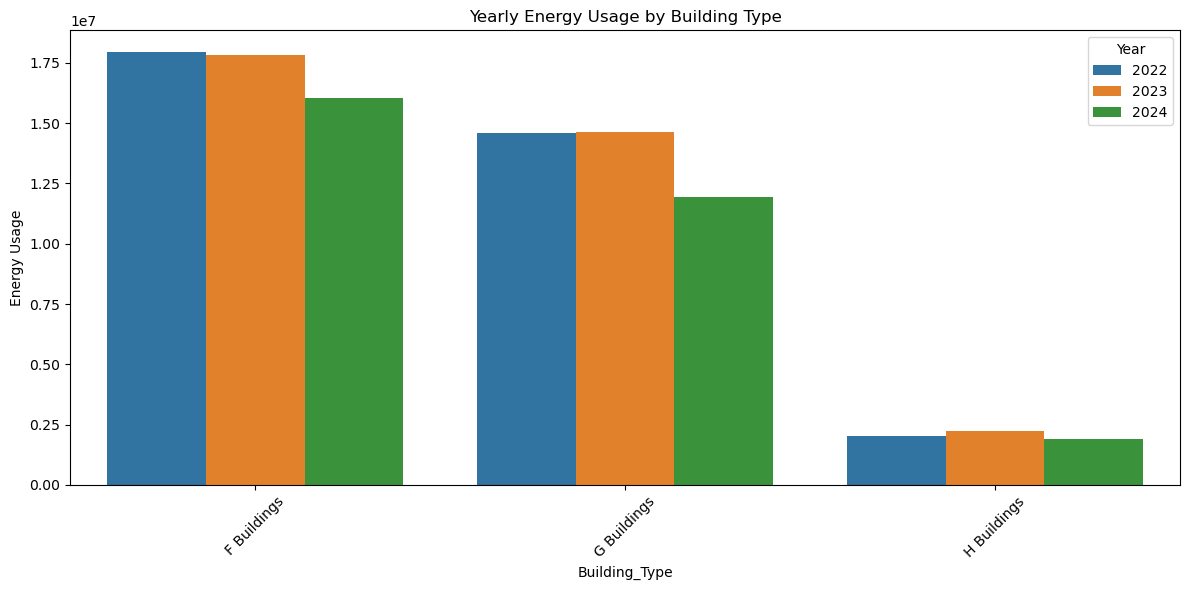


Summary Statistics:

F Buildings:
2022: 17,945,872.72
2023: 17,800,631.34
2024: 16,058,073.21

G Buildings:
2022: 14,572,273.81
2023: 14,643,240.87
2024: 11,923,773.34

H Buildings:
2022: 2,026,820.16
2023: 2,255,111.35
2024: 1,924,803.94


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('Combined_Cleaned_Data.csv')

# Function to extract numeric part and filter buildings
def filter_buildings(df, prefix, start, end):
    # Extract numeric part using string operations
    df['numeric_part'] = df['Meter_location'].str.extract('(\d+)').astype(float)
    mask = (df['Meter_location'].str.startswith(prefix)) & (df['numeric_part'].between(start, end))
    return df[mask]

# Filter buildings for each category
f_buildings = filter_buildings(df, 'F', 100, 500)
g_buildings = filter_buildings(df, 'G', 200, 500)
h_buildings = filter_buildings(df, 'H', 100, 432)

# Calculate yearly sums for each building type
def calculate_yearly_sums(buildings):
    # 2022 columns (Jan-Dec)
    cols_2022 = [col for col in buildings.columns if '2022' in col]
    # 2023 columns (Jan-Dec)
    cols_2023 = [col for col in buildings.columns if '2023' in col]
    # 2024 columns (Jan-Dec)
    cols_2024 = [col for col in buildings.columns if '2024' in col]
    
    return {
        '2022': buildings[cols_2022].sum().sum(),
        '2023': buildings[cols_2023].sum().sum(),
        '2024': buildings[cols_2024].sum().sum()
    }

# Calculate sums for each building type
f_sums = calculate_yearly_sums(f_buildings)
g_sums = calculate_yearly_sums(g_buildings)
h_sums = calculate_yearly_sums(h_buildings)

# Create DataFrame for plotting
yearly_data = pd.DataFrame({
    'Building_Type': ['F Buildings', 'F Buildings', 'F Buildings',
                     'G Buildings', 'G Buildings', 'G Buildings',
                     'H Buildings', 'H Buildings', 'H Buildings'],
    'Year': ['2022', '2023', '2024'] * 3,
    'Energy_Usage': [f_sums['2022'], f_sums['2023'], f_sums['2024'],
                    g_sums['2022'], g_sums['2023'], g_sums['2024'],
                    h_sums['2022'], h_sums['2023'], h_sums['2024']]
})

# Create box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Building_Type', y='Energy_Usage', data=yearly_data)
plt.title('Energy Usage Distribution by Building Type (2022-2024)')
plt.ylabel('Energy Usage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='Building_Type', y='Energy_Usage', hue='Year', data=yearly_data)
plt.title('Yearly Energy Usage by Building Type')
plt.ylabel('Energy Usage')
plt.xticks(rotation=45)
plt.legend(title='Year')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
for building_type, sums in [('F Buildings', f_sums), 
                          ('G Buildings', g_sums), 
                          ('H Buildings', h_sums)]:
    print(f"\n{building_type}:")
    print(f"2022: {sums['2022']:,.2f}")
    print(f"2023: {sums['2023']:,.2f}")
    print(f"2024: {sums['2024']:,.2f}")
